## KNN con CLS estratti dal longformer finetunato con task binario + topic LDA


In [1]:
import gensim
from gensim.utils import simple_preprocess
from nltk.stem.porter import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Lettura del dataset, esso è composto da 107577 record da 770 dimensioni, 768 dimensioni (cls longformer) + colonna Text + colonna Category

In [2]:
df = pd.read_csv(os.getcwd()+"/dataset/dataset_classification_bin.csv")
df = df[df['Text'].apply(lambda x: isinstance(x, str))]

### Suddivisione in train e test, salvaiamo le categarie in vettori seprarati dopo la split , infine togliamo le colonne Text e Category¶

In [3]:
train_knn , test_knn = train_test_split(df, test_size=0.2, random_state=42)
train_cat = train_knn["Categoria"]
test_cat = test_knn["Categoria"]
train_text = train_knn["Text"]
test_text = test_knn["Text"]
train_knn.drop('Categoria', axis=1, inplace=True)
test_knn.drop('Categoria', axis=1, inplace=True)
train_knn.drop('Text', axis=1, inplace=True)
test_knn.drop('Text', axis=1, inplace=True)

### Ogni documento (di train)  viene suddiviso in parole utilizzando il metodo split. Viene creato un dizionario, il quale mappa ogni parola univoca a un ID specifico (numerico). dictionary.filter_extremes filtra i token nel dizionario eliminando quelli che appaiono in meno di 15 documenti (no_below=15) o in più del 50% dei documenti (no_above=0.5) e mantiene solo i primi 10.000 token più frequenti (keep_n=10000) . Infine veiene creato il corpus Bag of Words (BoW) 

In [4]:
processe_docs = df["Text"]
processed_docs = [doc.split() for doc in processe_docs ]

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

### Allenamento modello Latent Dirichlet Allocation (LDA)     num_topics=5 per modellare 5 topic distinti

In [5]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=12, 
                                       id2word=dictionary, 
                                       passes=32,
                                       workers=2)

### Funzioni per : estrarre da ciascuno testo la distribuzione di probabilità dei topic utilizzando LDA; normalizzare questi punteggi;  aggiungere  agli  embeddings CLS  questi punteggi normalizzati.

In [6]:
def get_document_topics(bow):
    return [prob for topic, prob in lda_model.get_document_topics(bow)]
def get_lda_topic_scores(document, dictionary, lda_model):
    bow = dictionary.doc2bow(document.split())
    topic_scores = np.zeros(lda_model.num_topics)
    for topic, score in lda_model.get_document_topics(bow):
        topic_scores[topic] = score
    return topic_scores


def normalize_scores(scores):
    score_sum = sum(scores)
    if score_sum > 0:
        return [score / score_sum for score in scores]
    else:
        return [0 for score in scores]

def augment_embeddings_with_topics(embeddings, normalized_scores):
    normalized_scores_array = np.array(normalized_scores)
    
    if embeddings.shape[0] != normalized_scores_array.shape[0]:
        raise ValueError("Il numero di embeddings non corrisponde al numero di set di punteggi dei topic.")
    
    # Concateniamo gli embeddings con i punteggi dei topic ,ogni riga sarà embeddings + 5 valori dati da lda
    augmented_embeddings = np.concatenate([embeddings, normalized_scores_array], axis=1)
    
    return augmented_embeddings


In [7]:
#non cè bisogno di queste
processe_docs = train_text
processed_docs = [doc.split() for doc in processe_docs ]

### Calcolo dei punteggi

In [8]:
all_lda_scores = []

for doc in processe_docs:
    lda_scores = get_lda_topic_scores(doc, dictionary, lda_model)
    all_lda_scores.append(lda_scores)


### Normalizzazione

In [9]:
normalized_scores = [normalize_scores(score) for score in all_lda_scores ]
embeddings_array = train_knn.to_numpy()

### aggiungiamo le distribuzioni di prob ai CLS

In [10]:
augmented_embeddings = augment_embeddings_with_topics(embeddings_array, normalized_scores)
augmented_embeddings_train_df = pd.DataFrame(augmented_embeddings)


### Stessa procedura per i dati di test

In [11]:
processe_docs = test_text
processed_docs = [doc.split() for doc in processe_docs ]


In [12]:
all_lda_scores = []

for doc in processe_docs:
    lda_scores = get_lda_topic_scores(doc, dictionary, lda_model)
    all_lda_scores.append(lda_scores)


In [13]:
normalized_scores = [normalize_scores(score) for score in all_lda_scores ]
embeddings_array = test_knn.to_numpy()

In [14]:
augmented_embeddings = augment_embeddings_with_topics(embeddings_array, normalized_scores)
augmented_embeddings_test_df = pd.DataFrame(augmented_embeddings)

augmented_embeddings_test_df

,0,1,2,3,4,5,6,7,8,9,...,770,771,772,773,774,775,776,777,778,779
0,-0.185957,-0.152090,-0.039774,-0.025899,0.223613,0.371930,-0.209128,-0.205658,0.005404,-0.203321,...,0.00000,0.000000,0.000000,0.107901,0.000000,0.670267,0.124895,0.000000,0.000000,0.096937
1,0.084809,0.428122,0.609597,0.324390,-0.657671,-0.225295,0.480140,0.253494,0.421042,0.717039,...,0.00000,0.000000,0.359833,0.000000,0.000000,0.000000,0.000000,0.640167,0.000000,0.000000
2,0.428661,1.228725,0.469699,-0.015873,-0.604765,-1.337400,0.689755,1.091121,-0.088779,1.244117,...,0.00000,0.284388,0.623744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091868
3,0.444098,1.155454,0.302542,0.011765,-0.533903,-1.271184,0.573332,1.008424,-0.179122,1.071976,...,0.00000,0.073762,0.397556,0.000000,0.220539,0.000000,0.000000,0.000000,0.000000,0.308143
4,-0.189541,-0.112216,-0.040217,-0.020892,0.185741,0.354646,-0.192109,-0.213002,0.003298,-0.178339,...,0.14544,0.000000,0.000000,0.000000,0.000000,0.610412,0.150913,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21510,-0.296937,-0.531894,0.368840,0.321512,-0.144612,0.761936,-0.108818,-0.484896,0.500990,-0.059220,...,0.00000,0.000000,0.611995,0.000000,0.000000,0.000000,0.000000,0.045981,0.000000,0.000000
21511,-0.245641,-0.569066,0.408759,0.337376,-0.189073,0.722923,-0.070080,-0.491304,0.532992,-0.020430,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.691382,0.071168,0.237450,0.000000,0.000000
21512,0.292113,-0.049738,-0.452391,-0.211374,0.255740,-0.079297,-0.108347,0.030799,-0.417888,-0.467148,...,0.13550,0.000000,0.000000,0.225905,0.000000,0.413441,0.000000,0.000000,0.225154,0.000000
21513,0.439190,1.225078,0.474550,-0.010813,-0.587402,-1.346735,0.691542,1.099873,-0.095088,1.252788,...,0.00000,0.398479,0.000000,0.275979,0.000000,0.000000,0.000000,0.115508,0.210034,0.000000


### Creazione KNN, impostazione del paramentro K e allenamento

In [15]:

knn_classifier = KNeighborsClassifier(n_neighbors=31)
knn_classifier.fit(augmented_embeddings_train_df, train_cat)

KNeighborsClassifier(n_neighbors=31)

### Chiamiamo la funzione predict del KNN sul test

In [16]:
predizioni = knn_classifier.predict(augmented_embeddings_test_df)

### Calcolo Metriche

In [17]:

print(accuracy_score(test_cat,predizioni))
print(precision_score(test_cat,predizioni, average='macro'))
print(recall_score(test_cat,predizioni, average='macro'))
print(f1_score(test_cat,predizioni, average='macro'))
print(confusion_matrix(test_cat,predizioni))


0.8432721357192656
0.8153078033176504
0.830376990324867
0.8221547606726967
[[3951   30  318   98  648]
 [   5  229   17    8   36]
 [ 324   21 4211  169  305]
 [  72   16  166 4723  191]
 [ 463   37  328  120 5029]]


### Matrice di confusione 

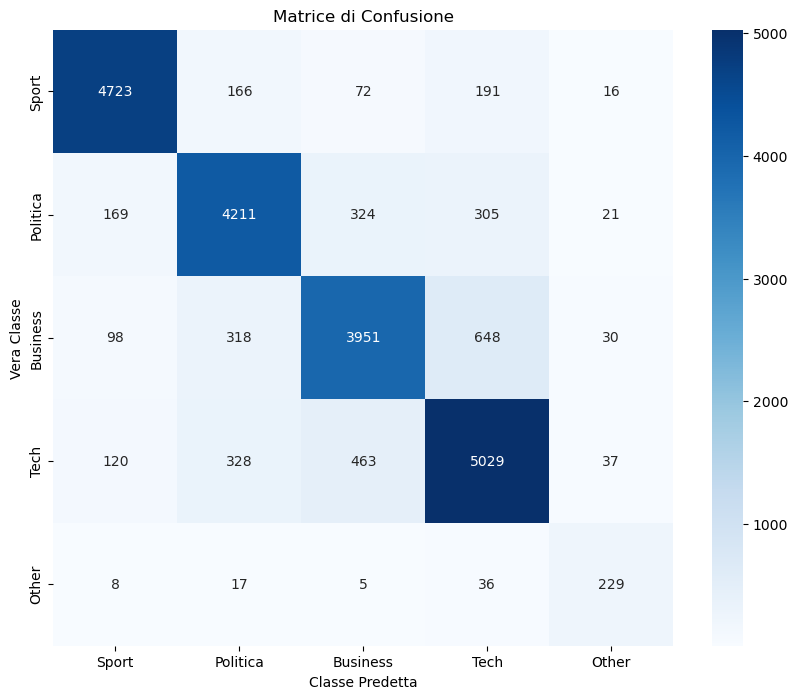

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
matrice_confusione = confusion_matrix(test_cat, predizioni, labels=['sport', 'politics', 'business', 'tech', 'other'])

# Etichette per le classi
classi = ['Sport', 'Politica', 'Business', 'Tech', 'Other']

# Creazione del grafico
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_confusione, annot=True, fmt="d", cmap="Blues", xticklabels=classi, yticklabels=classi)

# Aggiunta del titolo e degli assi
plt.title('Matrice di Confusione')
plt.ylabel('Vera Classe')
plt.xlabel('Classe Predetta')

# Visualizzazione del grafico
plt.show()